In [69]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# Load times from CVC4 or timeout
def load_cvc4_data(filename):
    with open(filename, 'r') as f:
        data = json.load(f)

    times = {}
    for theorem, entry in data.items():
        if entry['method'] == 'cvc5':
            times[theorem] = entry['total_time'] / 1000 # time is in ms
        else:
            times[theorem] = None
    return times

# Load times from E-Graph file
def load_egraph_data(filename):
    with open(filename, 'r') as f:
        data = json.load(f)

    return {theorem: float(entry['summary']['total_time']) for theorem, entry in data.items() if entry['summary']['stop_reason'] == {"Other":"Found equivalence"}}

# Load all three sources
file1 = './data/rover/lemma/parsed.json'
file2 = './data/rover/no_lemma/parsed.json'
file3 = './data/rover/egraph_stats.json'

lemma_times = load_cvc4_data(file1)
no_lemma_times = load_cvc4_data(file2)
egraph_times = load_egraph_data(file3)

# Combine into a DataFrame
df = pd.DataFrame({
    'lemma': lemma_times,
    'no_lemma': no_lemma_times,
    'egraph': egraph_times
})

df = df.sort_values(by=['lemma', 'no_lemma', 'egraph'], ascending=False, na_position='first')

In [70]:
latex_table = df.to_latex(
    index=True,       # include theorem names
    na_rep='-',       # replace NaNs with dashes
    float_format="%.3g"  # format floats
)

print(latex_table)
with open("./out/rover_table.tex", "w") as f:
    f.write(latex_table)

\begin{tabular}{lrrr}
\toprule
 & lemma & no_lemma & egraph \\
\midrule
one_to_two_mult & - & - & 0.000268 \\
merge_left_shift & - & - & 0.000187 \\
add_right_shift & - & - & 0.000173 \\
merge_right_shift & - & - & 0.000141 \\
left_shift_mult & - & - & 0.000136 \\
left_shift_add_2 & 286 & - & 0.000183 \\
sum_same & 279 & 277 & 3.28e-05 \\
left_shift_add_1 & 279 & - & 0.000261 \\
mul_two & 265 & - & 2.24e-05 \\
mult_sum_same & 130 & - & 0.000233 \\
add_assoc_1 & 104 & - & 0.000128 \\
add_assoc_3 & 75 & - & 0.000126 \\
mult_assoc_1 & 73.5 & - & 0.000133 \\
add_assoc_2 & 62.5 & - & 9.13e-05 \\
mult_assoc_2 & 59.9 & - & 0.000134 \\
dist_over_add & 38.7 & - & 0.000134 \\
mult_assoc_3 & 37.6 & - & 8.97e-05 \\
add_assoc_4 & 31.8 & - & 8.85e-05 \\
add_zero & 27.1 & - & 6.9e-05 \\
mul_one & 7.59 & - & 7.21e-05 \\
mult_assoc_4 & 6.28 & - & 0.000151 \\
sub_to_neg & 2.46 & 2.39 & 2.56e-05 \\
commutativity_mult & 1.57 & 1.76 & 2.61e-05 \\
commutativity_add & 1.31 & 1.57 & 2.87e-05 \\
\bottomrule
\e

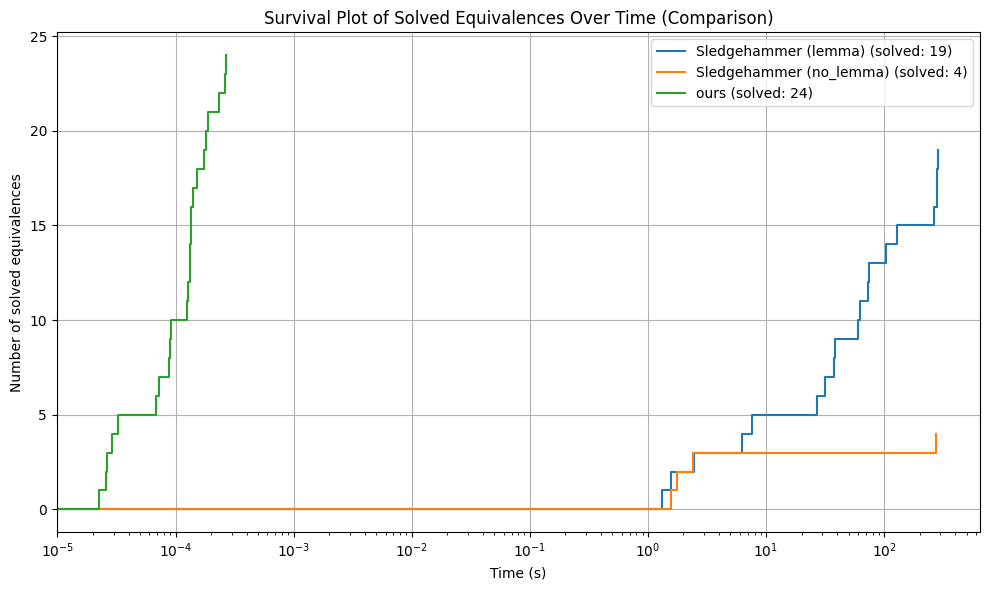

In [71]:

# Function to prepare step data for plotting
def prepare_step_data(series):
    times = sorted([t for t in series.dropna() if t is not None])
    x = [0]
    y = [0]
    for i, t in enumerate(times, start=1):
        x.extend([t, t])
        y.extend([y[-1], i])
    return x, y

# Prepare data for plotting
x1, y1 = prepare_step_data(df['lemma'])
x2, y2 = prepare_step_data(df['no_lemma'])
x3, y3 = prepare_step_data(df['egraph'])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x1, y1, drawstyle='steps-post', label=f'Sledgehammer (lemma) (solved: {len(df["lemma"].dropna())})')
plt.plot(x2, y2, drawstyle='steps-post', label=f'Sledgehammer (no_lemma) (solved: {len(df["no_lemma"].dropna())})')
plt.plot(x3, y3, drawstyle='steps-post', label=f'ours (solved: {len(df["egraph"].dropna())})')

plt.xlabel('Time (s)')
plt.ylabel('Number of solved equivalences')
plt.title('Survival Plot of Solved Equivalences Over Time (Comparison)')
plt.xscale('log')
# plt.ylim([0, 24])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('./out/rover_cactus.pdf')
plt.show()
